In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [ ]:
# ----------------------------
# 0) Reproducibility + device
# ----------------------------
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


In [ ]:
# ----------------------------
# 1) Data (same idea as NumPy code)
# ----------------------------
n = 512
x = np.random.uniform(-np.pi, np.pi, size=(n, 1)).astype(np.float32)
y = np.sin(x).astype(np.float32)

# Normalize inputs (helps training)
x_mean, x_std = x.mean(), x.std()
x_n = (x - x_mean) / x_std

# Convert to torch tensors
x_t = torch.from_numpy(x_n).to(device)   # normalized x
y_t = torch.from_numpy(y).to(device)     # target y

device: cpu
step   500 | loss 0.020976
step  1000 | loss 0.009910
step  1500 | loss 0.007763
step  2000 | loss 0.005409
step  2500 | loss 0.004640
step  3000 | loss 0.003729
step  3500 | loss 0.003279
step  4000 | loss 0.002946
step  4500 | loss 0.002237
step  5000 | loss 0.002065
step  5500 | loss 0.001884
step  6000 | loss 0.001834
step  6500 | loss 0.001504
step  7000 | loss 0.001434
step  7500 | loss 0.001505
step  8000 | loss 0.001091
step  8500 | loss 0.001103
step  9000 | loss 0.001040
step  9500 | loss 0.000948
step 10000 | loss 0.001327
step 10500 | loss 0.002854
step 11000 | loss 0.000815
step 11500 | loss 0.001461
step 12000 | loss 0.000767
step 12500 | loss 0.001077
step 13000 | loss 0.001295
step 13500 | loss 0.002115
step 14000 | loss 0.007836
step 14500 | loss 0.002316
step 15000 | loss 0.001194
step 15500 | loss 0.000783
step 16000 | loss 0.001084
step 16500 | loss 0.001251
step 17000 | loss 0.000766
step 17500 | loss 0.002201
step 18000 | loss 0.000698
step 18500 | los

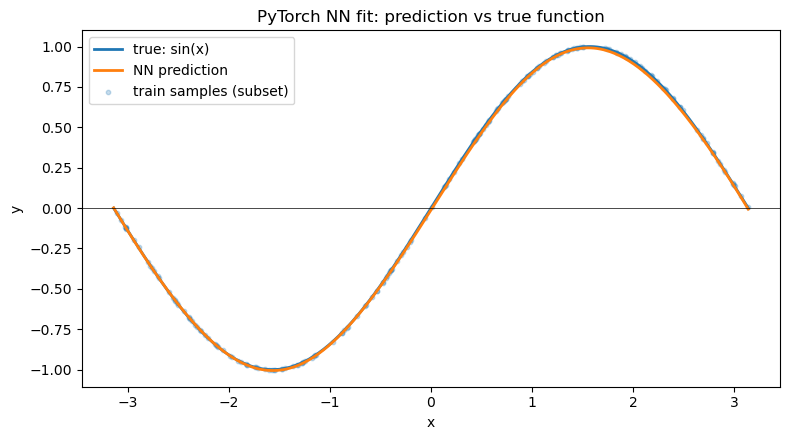

In [ ]:
# ----------------------------
# 2) Model definition (same architecture)
# ----------------------------
H = 32

class MLP_1hidden(nn.Module):
    """
    f(x) = (tanh(x W1 + b1)) W2 + b2
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)   # x -> hidden
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)   # hidden -> y

    def forward(self, x):
        z1 = self.fc1(x)      # (B, H)
        a1 = self.act(z1)     # (B, H)
        yhat = self.fc2(a1)   # (B, 1)
        return yhat

model = MLP_1hidden(H).to(device)

# Optional: initialize weights similarly to your NumPy code (small random weights, zero biases)
with torch.no_grad():
    model.fc1.weight.normal_(mean=0.0, std=0.1)
    model.fc1.bias.zero_()
    model.fc2.weight.normal_(mean=0.0, std=0.1)
    model.fc2.bias.zero_()

In [ ]:
# ----------------------------
# 3) Loss + optimizer
# ----------------------------
# MSE loss = mean((yhat - y)^2)
criterion = nn.MSELoss()

# SGD does: theta <- theta - lr * grad
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)



In [ ]:
# ----------------------------
# 4) Training loop (mini-batch SGD)
# ----------------------------
batch = 256
steps = 150_000  # PyTorch converges fast here; increase if you want

for t in range(steps):
    idx = torch.randint(low=0, high=n, size=(batch,), device=device)
    xb = x_t[idx]   # (B, 1)
    yb = y_t[idx]   # (B, 1)

    # Forward pass: compute prediction
    yhat = model(xb)

    # Compute loss
    loss = criterion(yhat, yb)

    # Backward pass: compute gradients dL/dtheta automatically
    optimizer.zero_grad()   # IMPORTANT: clear old gradients
    loss.backward()         # fills .grad for each parameter
    optimizer.step()        # updates parameters using those gradients

    if (t + 1) % 500 == 0:
        print(f"step {t+1:5d} | loss {loss.item():.6f}")



In [ ]:
# ----------------------------
# 5) Evaluation + plot
# ----------------------------
# Test grid (in original x units)
x_grid = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1).astype(np.float32)
y_true = np.sin(x_grid).astype(np.float32)
x_grid_n = (x_grid - x_mean) / x_std

xg = torch.from_numpy(x_grid_n).to(device)

model.eval()
with torch.no_grad():
    y_pred = model(xg).cpu().numpy()

mse = np.mean((y_pred - y_true) ** 2)
print("test MSE:", mse)

plt.figure(figsize=(8, 4.5))
plt.plot(x_grid, y_true, label="true: sin(x)", linewidth=2)
plt.plot(x_grid, y_pred, label="NN prediction", linewidth=2)
plt.scatter(x[:200], y[:200], s=10, alpha=0.25, label="train samples (subset)")
plt.axhline(0, color="black", linewidth=0.5)
plt.title("PyTorch NN fit: prediction vs true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 6) (Pedagogical) What PyTorch is doing for you
# ----------------------------
# - model.parameters() contains W1, b1, W2, b2
# - loss.backward() applies the chain rule to compute all gradients:
#     dL/dW1, dL/db1, dL/dW2, dL/db2
# - optimizer.step() performs the SGD update using these gradients
